### Содержание
* [1. Описание](#descr)
* [2. Импорт библиотек](#libs)
* [3. Подготовка данных](#preparations)
* [4. Анализ условий применимости](#conditions)  
* [5. Основной анализ](#main)  
* [6. Вывод](#conclusion)  

## 1. Описание <a class='anchor' id='descr'>

https://www.kaggle.com/maliwan/video-games/data

Выборка данных игровой платформы с Steam с информацией о проданных товарах.

В списке товаров присутствую игры и программы.

Проведем дисперсионный анализ о влиянии наличия внутрии игровых достижений на формирование стоимости игры.
Нулевая гипотеза - внутриигровые достижения влияют на формирование стоимости, как один из маркетьинговых инструментов.
Альтернативная гипотеза - внутриигровые достижения не влияют на формирование стоимости.

Примечание:
Из-за того что каждый год какой-нибудь кризис, то цены на игры имеют тенденцию колебаться, но данных на основании которых можно построить модель в дата сете нет, по этому возьмем только один год.

## 2. Импорт библиотек <a class='anchor' id='libs'>

In [1]:
import numpy as np
import pandas as pd
import random as rnd
from datetime import date

from scipy.stats import normaltest, levene, f_oneway

import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
%matplotlib inline
import warnings


pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [2]:
DATASET_PATH = 'steam.csv'
df = pd.read_csv(DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

In [3]:
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


## 3. Подготовка данных <a class='anchor' id='preparations'>

In [4]:
def gaus_like(target, alpha = 0.05):
    qqplot(target, line='s')
    plt.show()

    stat, p = normaltest(target)
    
    if p > alpha:
        print('Распределение похоже на нормальное (Нулевая гипотеза не отвергается)')
    else:
        print('Распределение не похоже на нормальное (нулевая гипотеза отвергается)')
    print(f'p_value = {p}')

In [5]:
# Создаем признак наличия достижений
df['has_achievements'] = df['achievements'] > 0

In [6]:
# Преобразуем дату в год выпуска
df['release_year'] = pd.to_datetime(df.release_date).dt.year

In [7]:
# делаем признак "игра"
programs = 'Animation & Modeling|Utilities|Web Publishing|Audio Production|Design & Illustration|Education|Video Production'

df['game'] = ~df['genres'].str.contains(programs, regex=True)

In [8]:
# расчитываем на основании срелнего колическва владельцев сумму дохода
owners_min = pd.to_numeric(df['owners'].str.replace('-.*', '', regex = True))
owners_max = pd.to_numeric(df['owners'].str.replace('.*-', '', regex = True))
df['owners_mean'] = (owners_max -owners_min)/2 + owners_min

df['revenue'] = df['price'] * df['owners_mean']

<AxesSubplot:xlabel='revenue', ylabel='Density'>

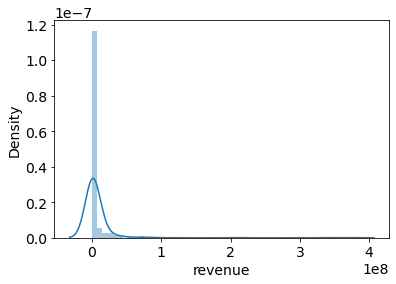

In [9]:
# для анализа возьмем только данные по не бесплатным играм выедшим в 2018 и в которые успели поиграть
cond = ((df['game']) & \
        (df['price'] > 0) & \
        (~df['genres'].str.contains('Early Access', regex=True))  & \
        (df['release_year'] == 2018) & \
        (df['median_playtime'] > 60))

target_df = df[cond]
sns.distplot(target_df['revenue'])

##  4. Анализ условий применимости <a class='anchor' id='conditions'>

Для проверки применимости дисперсионого анализа необходимо проверить следующие утверждения
1. Изучаемый признак нормально распределен в генеральной совокупности;
2. Дисперсии в сравниваемых генеральных совокупностях - равенствы;
3. Выборки случайны и независимы.

### 1. Изучаемый признак нормально распределен в генеральной совокупности;

<AxesSubplot:xlabel='revenue_log', ylabel='Density'>

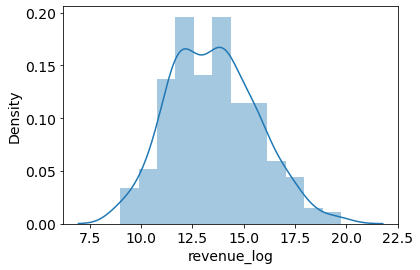

In [10]:
# Распределение целевого показателя похоже на лог нормальное
# Поэтому прологарифмируем целевую переменную

target_df['revenue_log'] = target_df['revenue'].apply(np.log)
sns.distplot(target_df['revenue_log'])

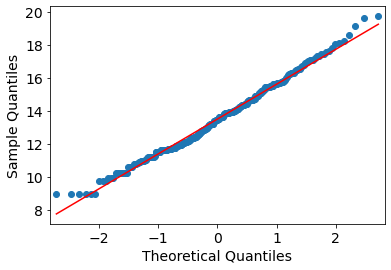

Распределение похоже на нормальное (Нулевая гипотеза не отвергается)
p_value = 0.1207234013902098


In [11]:
# Т.к. форма колокола прологорифмированых значений не дает полный ответ о нормальности распределения,
# протестируем гипотезу о нормальности распределения (Н0 - распределение является нормальным).

gaus_like(target_df['revenue_log'])

Утверждение о нормальном распределении признака подтверждено.

### 2. Дисперсии в сравниваемых генеральных совокупностях - равенствы;

In [12]:
# для анализа дисперсий используем тест Ливене
Sample1 = target_df[target_df['has_achievements']]['revenue_log']
Sample2 = target_df[~target_df['has_achievements']]['revenue_log']

stat, p = levene(Sample1 ,Sample2)
print(f'p_value = {p}')

p_value = 0.570796732156773


Т.к. p_value > 0.05, считаем что утверждение о равенстве дисперсий не может быть отвергнуто

### 3. Выборки случайны и независимы.

Выборки независимы исходя из способа их получения

##  5. Основной анализ <a class='anchor' id='main'>

In [13]:
f_stat, p_value = f_oneway(Sample1, Sample2)
p_value

0.0010104057872609624

##  6. Вывод <a class='anchor' id='conclusion'>

По результатам проверденного анализа можно сделать вывод о том, что на уровне значимости 5%
наличие внутриигровых достижений не оказывало влияние на формирование цены на игры выпущенные в 2018 году.